## Load CogAtlas data and assign categories to the paper

In [2]:
from neurovlm.retrieval_resources import (
    _load_dataframe,
    _load_latent_text,
    _load_latent_cogatlas,
    _load_latent_cogatlas_disorder,
    _load_latent_cogatlas_task,
     _load_cogatlas_dataset,
    _load_cogatlas_disorder_dataset,
    _load_cogatlas_task_dataset,
    _load_neuro_brain,
    _proj_head_image_infonce,
    _proj_head_text_infonce,
    _load_specter
)

from neurovlm.brain_input import search_cogatlas_from_brain
from neurovlm.text_input import search_cogatlas_from_text
from neurovlm.data import data_dir

import pandas as pd
from tqdm import tqdm
import torch


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Load and move models to device
proj_head_image = _proj_head_image_infonce().to(device)
proj_head_text = _proj_head_text_infonce().to(device)
specter = _load_specter()

There are adapters available but none are activated for the forward pass.


In [6]:
papers_df = _load_dataframe()
latent_papers, latent_pmid = _load_latent_text()

latent_brain, brain_pmid = _load_neuro_brain()

cogatlas_df = _load_cogatlas_dataset()
latent_cogatlas_concepts,cogatlas_concepts  = _load_latent_cogatlas()

cogatlas_disorder_df = _load_cogatlas_disorder_dataset()
latent_cogatlas_disorder, cogatlas_disorder = _load_latent_cogatlas_disorder()

cogatlas_task_df = _load_cogatlas_task_dataset(filtered=True)
latent_cogatlas_task, cogatlas_task = _load_latent_cogatlas_task()

## Assign labels to brain map for each category

In [ ]:
# Initialize lists to store results
pmids = []
cogatlas_concepts_list = []
cogatlas_disorders_list = []
cogatlas_tasks_list = []

# Loop through each paper
for i in tqdm(range(len(latent_papers))):
  paper_embedding = latent_papers[i]
  pmid = latent_pmid[i]

  # Get top 2 cogatlas concepts
  _, concepts, _ = search_cogatlas_from_text(
      query=paper_embedding,
      top_k=2,
      category="cogatlas"
  )

  # Get top 2 cogatlas disorders
  _, disorders, _ = search_cogatlas_from_text(
      query=paper_embedding,
      top_k=2,
      category="cogatlas_disorder"
  )

  # Get top 2 cogatlas tasks
  _, tasks, _ = search_cogatlas_from_text(
      query=paper_embedding,
      top_k=2,
      category="cogatlas_task"
  )

  # Store results
  pmids.append(pmid)
  cogatlas_concepts_list.append(concepts)
  cogatlas_disorders_list.append(disorders)
  cogatlas_tasks_list.append(tasks)

# Create dataframe
df_results = pd.DataFrame({
  'pmid': pmids,
  'cogatlas_concepts': cogatlas_concepts_list,
  'cogatlas_disorder': cogatlas_disorders_list,
  'cogatlas_task': cogatlas_tasks_list
})

df_results

## Load the data if file already exist

There are 4 columns
- pmid: The pmid of the paper the brain map was gotten from
- cogatlas_concepts: The top 2 concepts from the paper
- cogatlas_disorder: The top 2 disorders from the paper
- cogatlas_task: The top 2 tasks from the paper

In [3]:
df  = pd.read_parquet(data_dir / "paper_cogatlas_categories.parquet", engine="pyarrow")

# Train the neural net classifier

In [18]:
df

,pmid,cogatlas_concepts,cogatlas_disorder,cogatlas_task
0,1589767,"[speech processing, auditory working memory]","[speech disorder, articulation disorder]","[auditory scene perception, passive listening]"
1,8530552,"[attentional effort, vocal response execution]","[stroke, tetraplegia]","[isometric force, motor sequencing task]"
2,8624678,"[language processing, language]","[surface dyslexia, aphasia]","[semantic anomaly judgement task, orthographic..."
3,8670634,"[goal maintenance, active maintenance]","[tetraplegia, rigidity]","[articulatory suppression task, bimanual coord..."
4,8994101,"[pitch perception, spontaneous recovery]","[philoprogeria, periodic limb movement disorder]","[multistability, nine-hole peg test]"
...,...,...,...,...
30821,38828086,"[search, loss]","[somatization disorder, kleine-levin syndrome]","[brief symptom inventory, broader phenotype au..."
30822,38832323,"[behavioral inhibition, attentional effort]","[learning disability, writing disorder]","[oculomotor delayed response, braille reading ..."
30823,38832325,"[autobiographical recall, autobiographical mem...","[borderline personality disorder, anterograde ...","[broader phenotype autism symptom scale, immed..."
30824,38832358,"[auditory word comprehension, auditory word re...","[aphasia, verbal auditory agnosia]","[chewing/swallowing, abstract/concrete judgmen..."


In [ ]:
latent_cogatlas_disorder

In [ ]:
cogatlas_disorder

# Multi-Label Classification Pipeline

This notebook implements a comprehensive multi-label classification system to predict cognitive concepts, disorders, and tasks from brain maps.

In [9]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    hamming_loss, f1_score, precision_score, recall_score,
    classification_report, multilabel_confusion_matrix
)
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, List
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## Step 1: Data Preparation and Alignment

Align brain maps with their corresponding multi-label targets from the CogAtlas categories.

In [10]:
def prepare_training_data(latent_brain, brain_pmid, df):
    """
    Align brain maps with their labels and create training matrices.
    Applies projection head and normalization to brain embeddings.
    
    Args:
        latent_brain: Brain map embeddings tensor
        brain_pmid: PMIDs corresponding to brain maps
        df: DataFrame with pmid and category labels
        
    Returns:
        X: Brain map features (numpy array)
        y_concepts, y_disorders, y_tasks: Label lists for each category
        aligned_indices: Indices of successfully aligned samples
    """
    # Load projection head for brain images
    from neurovlm.retrieval_resources import _proj_head_image_infonce
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    
    proj_head_image = _proj_head_image_infonce().to(device)
    proj_head_image.eval()
    
    # Convert brain embeddings to tensor if needed
    if not isinstance(latent_brain, torch.Tensor):
        latent_brain = torch.tensor(latent_brain)
    
    # Move to device
    latent_brain = latent_brain.to(device)
    
    # Apply projection head and normalize
    with torch.no_grad():
        proj_brain = proj_head_image(latent_brain)
        # Normalize: proj_img = proj_img / proj_img.norm()
        proj_brain = proj_brain / proj_brain.norm(dim=1, keepdim=True)
    
    X_full = proj_brain.cpu().numpy()
    
    # Create PMID to index mapping for labels dataframe
    pmid_to_labels = df.set_index('pmid').to_dict('index')
    
    # Align brain maps with labels
    aligned_X = []
    aligned_concepts = []
    aligned_disorders = []
    aligned_tasks = []
    aligned_indices = []
    
    for idx, pmid in enumerate(brain_pmid):
        if pmid in pmid_to_labels:
            aligned_X.append(X_full[idx])
            labels = pmid_to_labels[pmid]
            aligned_concepts.append(labels['cogatlas_concepts'])
            aligned_disorders.append(labels['cogatlas_disorder'])
            aligned_tasks.append(labels['cogatlas_task'])
            aligned_indices.append(idx)
    
    X = np.array(aligned_X)
    
    print(f"Total brain maps: {len(brain_pmid)}")
    print(f"Aligned samples: {len(X)}")
    print(f"Brain map feature dimension (after projection): {X.shape[1]}")
    print(f"Match rate: {len(X)/len(brain_pmid)*100:.2f}%")
    print(f"Device used: {device}")
    
    return X, aligned_concepts, aligned_disorders, aligned_tasks, aligned_indices

# Prepare the data
X, y_concepts_raw, y_disorders_raw, y_tasks_raw, aligned_indices = prepare_training_data(
    latent_brain, brain_pmid, df
)

print(f"\nSample labels:")
print(f"Concepts example: {y_concepts_raw[0]}")
print(f"Disorders example: {y_disorders_raw[0]}")
print(f"Tasks example: {y_tasks_raw[0]}")

Total brain maps: 27501
Aligned samples: 27501
Brain map feature dimension (after projection): 384
Match rate: 100.00%
Device used: mps

Sample labels:
Concepts example: ['speech processing' 'auditory working memory']
Disorders example: ['speech disorder' 'articulation disorder']
Tasks example: ['auditory scene perception' 'passive listening']


## Step 2: Multi-Label Encoding

Convert list-based labels into binary matrices using MultiLabelBinarizer for each category.

In [11]:
def encode_multilabels(y_concepts, y_disorders, y_tasks):
    """
    Encode multi-label targets into embeddings using Specter and projection head.
    
    For each label:
    1. Encode text with Specter
    2. Normalize embedding
    3. Apply text projection head to align with brain latent space
    4. Normalize again
    
    Returns:
        Encoded labels (as embeddings), label names, and fitted binarizers for each category
    """
    from neurovlm.retrieval_resources import _load_specter, _proj_head_text_infonce

    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

    # Load and move models to device
    proj_head_text = _proj_head_text_infonce().to(device)
    specter = _load_specter()
    proj_head_text.eval()
    
    # Initialize binarizers to get unique label names
    mlb_concepts = MultiLabelBinarizer()
    mlb_disorders = MultiLabelBinarizer()
    mlb_tasks = MultiLabelBinarizer()
    
    # Fit binarizers to get all unique labels
    mlb_concepts.fit(y_concepts)
    mlb_disorders.fit(y_disorders)
    mlb_tasks.fit(y_tasks)
    
    print("Encoding labels with Specter and text projection head...")
    print(f"Using device: {device}")
    
    # Function to embed and project labels
    def embed_labels(label_names, category_name):
        print(f"\n  Processing {len(label_names)} {category_name} labels...")
        
        # Encode labels with Specter
        with torch.no_grad():
            embeddings = specter(list(label_names))
            
            # Move embeddings to device
            embeddings = embeddings.to(device)
            
            # Normalize embeddings
            embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
            
            # Apply text projection head
            proj_embeddings = proj_head_text(embeddings)
            
            # Normalize again
            proj_embeddings = proj_embeddings / proj_embeddings.norm(dim=1, keepdim=True)
        
        return proj_embeddings.cpu().numpy()
    
    # Embed all labels for each category
    concept_embeddings = embed_labels(mlb_concepts.classes_, "Concepts")
    disorder_embeddings = embed_labels(mlb_disorders.classes_, "Disorders")
    task_embeddings = embed_labels(mlb_tasks.classes_, "Tasks")
    
    # Also create binary encodings for compatibility with existing code
    y_concepts_encoded = mlb_concepts.transform(y_concepts)
    y_disorders_encoded = mlb_disorders.transform(y_disorders)
    y_tasks_encoded = mlb_tasks.transform(y_tasks)
    
    print("\nMulti-label encoding complete:")
    print(f"  Concepts: {y_concepts_encoded.shape[1]} unique labels")
    print(f"  Disorders: {y_disorders_encoded.shape[1]} unique labels")
    print(f"  Tasks: {y_tasks_encoded.shape[1]} unique labels")
    
    # Calculate label statistics
    print("\nLabel frequency statistics:")
    for name, encoded in [("Concepts", y_concepts_encoded), 
                          ("Disorders", y_disorders_encoded),
                          ("Tasks", y_tasks_encoded)]:
        labels_per_sample = encoded.sum(axis=1)
        samples_per_label = encoded.sum(axis=0)
        print(f"\n{name}:")
        print(f"  Avg labels per sample: {labels_per_sample.mean():.2f} ± {labels_per_sample.std():.2f}")
        print(f"  Min/Max labels per sample: {labels_per_sample.min()}/{labels_per_sample.max()}")
        print(f"  Avg samples per label: {samples_per_label.mean():.2f}")
        print(f"  Rarest label appears in: {samples_per_label.min()} samples")
        print(f"  Most common label appears in: {samples_per_label.max()} samples")
    
    return {
        'concepts': {
            'encoded': y_concepts_encoded, 
            'mlb': mlb_concepts,
            'embeddings': concept_embeddings
        },
        'disorders': {
            'encoded': y_disorders_encoded, 
            'mlb': mlb_disorders,
            'embeddings': disorder_embeddings
        },
        'tasks': {
            'encoded': y_tasks_encoded, 
            'mlb': mlb_tasks,
            'embeddings': task_embeddings
        }
    }

# Encode labels
encoded_labels = encode_multilabels(y_concepts_raw, y_disorders_raw, y_tasks_raw)

Encoding labels with Specter and text projection head...
Using device: mps

  Processing 293 Concepts labels...

  Processing 221 Disorders labels...

  Processing 299 Tasks labels...

Multi-label encoding complete:
  Concepts: 293 unique labels
  Disorders: 221 unique labels
  Tasks: 299 unique labels

Label frequency statistics:

Concepts:
  Avg labels per sample: 2.00 ± 0.01
  Min/Max labels per sample: 1/2
  Avg samples per label: 187.71
  Rarest label appears in: 1 samples
  Most common label appears in: 2181 samples

Disorders:
  Avg labels per sample: 2.00 ± 0.00
  Min/Max labels per sample: 2/2
  Avg samples per label: 248.88
  Rarest label appears in: 1 samples
  Most common label appears in: 2243 samples

Tasks:
  Avg labels per sample: 2.00 ± 0.01
  Min/Max labels per sample: 1/2
  Avg samples per label: 183.94
  Rarest label appears in: 1 samples
  Most common label appears in: 2680 samples


## Step 3: Train-Test Split

Create stratified splits for multi-label data to ensure balanced representation.

In [12]:
def create_train_test_split(X, encoded_labels, test_size=0.2, random_state=42):
    """
    Create train/test splits for features and all label categories.
    
    Note: For proper stratification with multi-label data, consider using
    iterstrat.ml_model_selection.IterativeStratification for production use.
    Here we use simple random split.
    """
    # Simple train-test split
    # For better stratification, install and use: 
    # from iterstrat.ml_model_selection import MultilabelStratifiedShuffleSplit
    
    indices = np.arange(len(X))
    train_idx, test_idx = train_test_split(
        indices, 
        test_size=test_size, 
        random_state=random_state
    )
    
    X_train, X_test = X[train_idx], X[test_idx]
    
    splits = {
        'X_train': X_train,
        'X_test': X_test,
        'train_idx': train_idx,
        'test_idx': test_idx
    }
    
    for category in ['concepts', 'disorders', 'tasks']:
        y_full = encoded_labels[category]['encoded']
        splits[f'y_{category}_train'] = y_full[train_idx]
        splits[f'y_{category}_test'] = y_full[test_idx]
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Split ratio: {len(X_test)/len(X)*100:.1f}% test")
    
    return splits

# Create splits
splits = create_train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

print("\nFeature shapes:")
print(f"X_train: {splits['X_train'].shape}")
print(f"X_test: {splits['X_test'].shape}")

Training set: 22000 samples
Test set: 5501 samples
Split ratio: 20.0% test

Feature shapes:
X_train: (22000, 384)
X_test: (5501, 384)


## Step 4: PCA Dimensionality Reduction

Apply PCA to reduce feature dimensionality and improve model performance.

In [13]:
def apply_pca(X_train, X_test, n_components=100):
    """
    Apply PCA dimensionality reduction.
    
    Args:
        X_train, X_test: Training and test features
        n_components: Number of components to keep
        
    Returns:
        Transformed features and fitted PCA object
    """
    pca = PCA(n_components=n_components, random_state=42)
    
    # Fit on training data only
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    explained_var = pca.explained_variance_ratio_.sum()
    
    print(f"PCA with {n_components} components:")
    print(f"  Original dimension: {X_train.shape[1]}")
    print(f"  Reduced dimension: {n_components}")
    print(f"  Explained variance: {explained_var*100:.2f}%")
    print(f"  Compression ratio: {X_train.shape[1]/n_components:.1f}x")
    
    return X_train_pca, X_test_pca, pca

# Try different PCA dimensions
pca_configs = [50, 100, 200]
pca_results = {}

for n_comp in pca_configs:
    X_train_pca, X_test_pca, pca = apply_pca(
        splits['X_train'], 
        splits['X_test'], 
        n_components=n_comp
    )
    pca_results[n_comp] = {
        'X_train': X_train_pca,
        'X_test': X_test_pca,
        'pca': pca
    }
    print()

# Use 100 components as default
X_train_pca = pca_results[100]['X_train']
X_test_pca = pca_results[100]['X_test']

PCA with 50 components:
  Original dimension: 384
  Reduced dimension: 50
  Explained variance: 79.11%
  Compression ratio: 7.7x

PCA with 100 components:
  Original dimension: 384
  Reduced dimension: 100
  Explained variance: 90.01%
  Compression ratio: 3.8x

PCA with 200 components:
  Original dimension: 384
  Reduced dimension: 200
  Explained variance: 97.86%
  Compression ratio: 1.9x



## Step 5: Evaluation Metrics

Define comprehensive evaluation functions for multi-label classification.

In [14]:
def evaluate_multilabel(y_true, y_pred, category_name="Category"):
    """
    Comprehensive evaluation for multi-label classification.
    
    Args:
        y_true: True binary labels
        y_pred: Predicted binary labels
        category_name: Name of the category for display
        
    Returns:
        Dictionary of metrics
    """
    metrics = {
        'hamming_loss': hamming_loss(y_true, y_pred),
        'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_samples': f1_score(y_true, y_pred, average='samples', zero_division=0),
        'precision_micro': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_micro': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
    }
    
    print(f"\n{category_name} Evaluation:")
    print(f"  Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"  F1 Score (micro): {metrics['f1_micro']:.4f}")
    print(f"  F1 Score (macro): {metrics['f1_macro']:.4f}")
    print(f"  F1 Score (samples): {metrics['f1_samples']:.4f}")
    print(f"  Precision (micro): {metrics['precision_micro']:.4f}")
    print(f"  Recall (micro): {metrics['recall_micro']:.4f}")
    
    return metrics

def optimize_threshold(y_true, y_proba, metric='f1_micro'):
    """
    Find optimal threshold for converting probabilities to binary predictions.
    
    Args:
        y_true: True binary labels
        y_proba: Predicted probabilities
        metric: Metric to optimize ('f1_micro', 'f1_macro', or 'f1_samples')
        
    Returns:
        Best threshold value
    """
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_score = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        if metric == 'f1_micro':
            score = f1_score(y_true, y_pred, average='micro', zero_division=0)
        elif metric == 'f1_macro':
            score = f1_score(y_true, y_pred, average='macro', zero_division=0)
        else:  # f1_samples
            score = f1_score(y_true, y_pred, average='samples', zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score

print("Evaluation functions defined")

Evaluation functions defined


## Step 6: Ridge Regression Baseline

Train Ridge regression models as baseline for each category.

In [16]:
def train_ridge_model(X_train, y_train, X_test, y_test, alpha=1.0, category_name="Category"):
    """
    Train a Ridge regression model for multi-label classification.
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Test data
        alpha: Regularization strength
        category_name: Name for display
        
    Returns:
        Trained model and predictions
    """
    print(f"\nTraining Ridge model for {category_name}...")
    print(f"  Alpha: {alpha}")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Number of labels: {y_train.shape[1]}")
    
    # Use Ridge directly for multi-output regression
    # Ridge can handle multi-output natively
    model = Ridge(alpha=alpha, random_state=42)
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict (continuous outputs)
    y_pred_proba = model.predict(X_test)
    
    # Clip predictions to [0, 1] range for probability interpretation
    y_pred_proba = np.clip(y_pred_proba, 0, 1)
    
    # Apply threshold
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Evaluate
    metrics = evaluate_multilabel(y_test, y_pred, category_name)
    
    # Optimize threshold
    best_threshold, best_score = optimize_threshold(y_test, y_pred_proba, metric='f1_micro')
    y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)
    print(f"\n  Optimized threshold: {best_threshold:.2f} (F1-micro: {best_score:.4f})")
    
    metrics_optimized = evaluate_multilabel(y_test, y_pred_optimized, f"{category_name} (Optimized)")
    
    return {
        'model': model,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred,
        'y_pred_optimized': y_pred_optimized,
        'metrics': metrics,
        'metrics_optimized': metrics_optimized,
        'best_threshold': best_threshold
    }

# Train Ridge models for all categories
ridge_results = {}

for category in ['concepts', 'disorders', 'tasks']:
    ridge_results[category] = train_ridge_model(
        X_train_pca,
        splits[f'y_{category}_train'],
        X_test_pca,
        splits[f'y_{category}_test'],
        alpha=1.0,
        category_name=category.capitalize()
    )


Training Ridge model for Concepts...
  Alpha: 1.0
  Training samples: 22000
  Number of labels: 293

Concepts Evaluation:
  Hamming Loss: 0.0068
  F1 Score (micro): 0.0000
  F1 Score (macro): 0.0000
  F1 Score (samples): 0.0000
  Precision (micro): 0.0000
  Recall (micro): 0.0000

  Optimized threshold: 0.10 (F1-micro: 0.1179)

Concepts (Optimized) Evaluation:
  Hamming Loss: 0.0093
  F1 Score (micro): 0.1179
  F1 Score (macro): 0.0168
  F1 Score (samples): 0.0923
  Precision (micro): 0.1657
  Recall (micro): 0.0915

Training Ridge model for Disorders...
  Alpha: 1.0
  Training samples: 22000
  Number of labels: 221

Disorders Evaluation:
  Hamming Loss: 0.0090
  F1 Score (micro): 0.0069
  F1 Score (macro): 0.0007
  F1 Score (samples): 0.0043
  Precision (micro): 0.6909
  Recall (micro): 0.0035

  Optimized threshold: 0.10 (F1-micro: 0.1659)

Disorders (Optimized) Evaluation:
  Hamming Loss: 0.0147
  F1 Score (micro): 0.1659
  F1 Score (macro): 0.0216
  F1 Score (samples): 0.1313
  Pr

## Step 7: CatBoost Models

Train CatBoost classifiers for improved performance. Using separate binary classifiers for each label (one-vs-rest).

In [19]:
def train_catboost_multilabel(X_train, y_train, X_test, y_test, category_name="Category"):
    """
    Train CatBoost models for multi-label classification using one-vs-rest approach.
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Test data
        category_name: Name for display
        
    Returns:
        List of trained models and predictions
    """
    print(f"\nTraining CatBoost models for {category_name}...")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Number of labels: {y_train.shape[1]}")
    
    n_labels = y_train.shape[1]
    models = []
    predictions_proba = []
    
    # Train one binary classifier per label
    for label_idx in range(n_labels):
        if label_idx % 50 == 0:
            print(f"  Training label {label_idx + 1}/{n_labels}...")
        
        # Get binary target for this label
        y_train_binary = y_train[:, label_idx]
        
        # Skip if label is too rare
        if y_train_binary.sum() < 5:
            models.append(None)
            predictions_proba.append(np.zeros(len(X_test)))
            continue
        
        # Create and train CatBoost classifier
        model = CatBoostClassifier(
            iterations=100,
            depth=4,
            learning_rate=0.1,
            loss_function='Logloss',
            random_seed=42,
            verbose=False,
            auto_class_weights='Balanced'  # Handle class imbalance
        )
        
        model.fit(X_train, y_train_binary)
        
        # Predict probabilities
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        models.append(model)
        predictions_proba.append(y_pred_proba)
    
    # Stack predictions
    y_pred_proba = np.column_stack(predictions_proba)
    
    # Apply threshold
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Evaluate
    metrics = evaluate_multilabel(y_test, y_pred, category_name)
    
    # Optimize threshold
    best_threshold, best_score = optimize_threshold(y_test, y_pred_proba, metric='f1_micro')
    y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)
    print(f"\n  Optimized threshold: {best_threshold:.2f} (F1-micro: {best_score:.4f})")
    
    metrics_optimized = evaluate_multilabel(y_test, y_pred_optimized, f"{category_name} (Optimized)")
    
    return {
        'models': models,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred,
        'y_pred_optimized': y_pred_optimized,
        'metrics': metrics,
        'metrics_optimized': metrics_optimized,
        'best_threshold': best_threshold
    }

# Train CatBoost models for all categories
catboost_results = {}

for category in ['concepts', 'disorders', 'tasks']:
    catboost_results[category] = train_catboost_multilabel(
        X_train_pca,
        splits[f'y_{category}_train'],
        X_test_pca,
        splits[f'y_{category}_test'],
        category_name=category.capitalize()
    )


Training CatBoost models for Concepts...
  Training samples: 22000
  Number of labels: 293
  Training label 1/293...
  Training label 51/293...
  Training label 101/293...
  Training label 151/293...
  Training label 201/293...
  Training label 251/293...

Concepts Evaluation:
  Hamming Loss: 0.0613
  F1 Score (micro): 0.0780
  F1 Score (macro): 0.0341
  F1 Score (samples): 0.0779
  Precision (micro): 0.0434
  Recall (micro): 0.3797

  Optimized threshold: 0.70 (F1-micro: 0.1097)

Concepts (Optimized) Evaluation:
  Hamming Loss: 0.0148
  F1 Score (micro): 0.1097
  F1 Score (macro): 0.0395
  F1 Score (samples): 0.0835
  Precision (micro): 0.0932
  Recall (micro): 0.1332

Training CatBoost models for Disorders...
  Training samples: 22000
  Number of labels: 221
  Training label 1/221...
  Training label 51/221...
  Training label 101/221...
  Training label 151/221...
  Training label 201/221...

Disorders Evaluation:
  Hamming Loss: 0.0768
  F1 Score (micro): 0.0881
  F1 Score (macro)

## Step 8: Model Comparison and Visualization

Compare Ridge and CatBoost performance across all categories.


MODEL COMPARISON (with optimized thresholds)
 Category    Model  F1-Micro  F1-Macro  F1-Samples  Hamming Loss  Precision   Recall
 Concepts    Ridge  0.117923  0.016824    0.092275      0.009347   0.165707 0.091529
 Concepts CatBoost  0.109680  0.039507    0.083478      0.014756   0.093241 0.133158
Disorders    Ridge  0.165874  0.021556    0.131258      0.014709   0.170372 0.161607
Disorders CatBoost  0.134532  0.044371    0.105327      0.017896   0.119615 0.153699
    Tasks    Ridge  0.184904  0.016995    0.165295      0.012934   0.159822 0.219324
    Tasks CatBoost  0.130984  0.037553    0.117052      0.018619   0.095218 0.209780


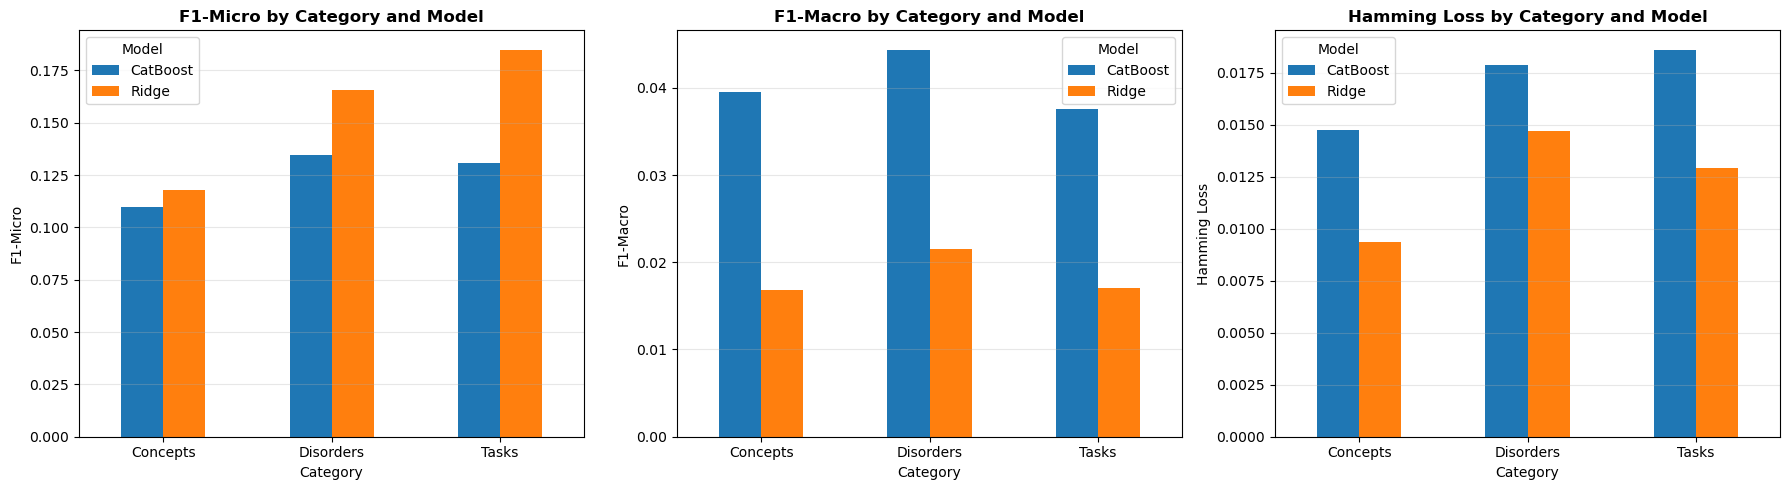


BEST MODEL PER CATEGORY (by F1-Micro)
Concepts: Ridge (F1-Micro: 0.1179)
Disorders: Ridge (F1-Micro: 0.1659)
Tasks: Ridge (F1-Micro: 0.1849)


In [20]:
# Create comparison dataframe
comparison_data = []

for category in ['concepts', 'disorders', 'tasks']:
    # Ridge results
    ridge_metrics = ridge_results[category]['metrics_optimized']
    comparison_data.append({
        'Category': category.capitalize(),
        'Model': 'Ridge',
        'F1-Micro': ridge_metrics['f1_micro'],
        'F1-Macro': ridge_metrics['f1_macro'],
        'F1-Samples': ridge_metrics['f1_samples'],
        'Hamming Loss': ridge_metrics['hamming_loss'],
        'Precision': ridge_metrics['precision_micro'],
        'Recall': ridge_metrics['recall_micro']
    })
    
    # CatBoost results
    catboost_metrics = catboost_results[category]['metrics_optimized']
    comparison_data.append({
        'Category': category.capitalize(),
        'Model': 'CatBoost',
        'F1-Micro': catboost_metrics['f1_micro'],
        'F1-Macro': catboost_metrics['f1_macro'],
        'F1-Samples': catboost_metrics['f1_samples'],
        'Hamming Loss': catboost_metrics['hamming_loss'],
        'Precision': catboost_metrics['precision_micro'],
        'Recall': catboost_metrics['recall_micro']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON (with optimized thresholds)")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['F1-Micro', 'F1-Macro', 'Hamming Loss']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    pivot_data = comparison_df.pivot(index='Category', columns='Model', values=metric)
    pivot_data.plot(kind='bar', ax=ax, rot=0)
    
    ax.set_title(f'{metric} by Category and Model', fontsize=12, fontweight='bold')
    ax.set_xlabel('Category', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.legend(title='Model')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Show best model per category
print("\n" + "="*80)
print("BEST MODEL PER CATEGORY (by F1-Micro)")
print("="*80)
for category in ['Concepts', 'Disorders', 'Tasks']:
    category_df = comparison_df[comparison_df['Category'] == category]
    best_row = category_df.loc[category_df['F1-Micro'].idxmax()]
    print(f"{category}: {best_row['Model']} (F1-Micro: {best_row['F1-Micro']:.4f})")

## Step 9: Per-Label Performance Analysis

Analyze which labels are easiest/hardest to predict.

In [ ]:
def analyze_per_label_performance(y_true, y_pred, mlb, category_name="Category", top_k=10):
    """
    Analyze performance for individual labels.
    
    Args:
        y_true: True binary labels
        y_pred: Predicted binary labels
        mlb: Fitted MultiLabelBinarizer
        category_name: Name for display
        top_k: Number of top/bottom labels to show
    """
    n_labels = y_true.shape[1]
    label_names = mlb.classes_
    
    # Calculate per-label metrics
    label_stats = []
    
    for i in range(n_labels):
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]
        
        # Calculate metrics
        tp = ((y_true_label == 1) & (y_pred_label == 1)).sum()
        fp = ((y_true_label == 0) & (y_pred_label == 1)).sum()
        fn = ((y_true_label == 1) & (y_pred_label == 0)).sum()
        tn = ((y_true_label == 0) & (y_pred_label == 0)).sum()
        
        support = y_true_label.sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        label_stats.append({
            'label': label_names[i],
            'support': support,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn
        })
    
    # Convert to dataframe
    stats_df = pd.DataFrame(label_stats)
    stats_df = stats_df[stats_df['support'] > 0].sort_values('f1', ascending=False)
    
    print(f"\n{'='*80}")
    print(f"{category_name} - Per-Label Performance Analysis")
    print(f"{'='*80}")
    
    print(f"\nTop {top_k} Best Performing Labels:")
    print(stats_df.head(top_k)[['label', 'f1', 'precision', 'recall', 'support']].to_string(index=False))
    
    print(f"\nTop {top_k} Worst Performing Labels:")
    print(stats_df.tail(top_k)[['label', 'f1', 'precision', 'recall', 'support']].to_string(index=False))
    
    print(f"\nOverall Statistics:")
    print(